# **Exercise 2 - The Eight Point Algorithm**

## **Implementation of the Algorithm**

We have two images and we manually annotated 10 correspondences $\{x_i, x_i'\}_{i=1}^{10}$ between them. Once we have these points, we can implement the eight points algorithm (note that here we don't need additional points because there is no noise in the annotation as, again, they were manually - and very carefully - done). <br>

First, we import the necessary libraries.

In [ ]:
## IMPORTS
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy import linalg as la

Then, we upload the images as <code>img1</code> and <code>img2</code>, we convert the pictures to RGB and plot them one next to the other.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path1 = '/content/drive/MyDrive/CV Assignment 1/IMG_2420.jpg'
path2 = '/content/drive/MyDrive/CV Assignment 1/IMG_2421.jpg'

Mounted at /content/drive


Text(0.5, 1.0, 'Image 2')

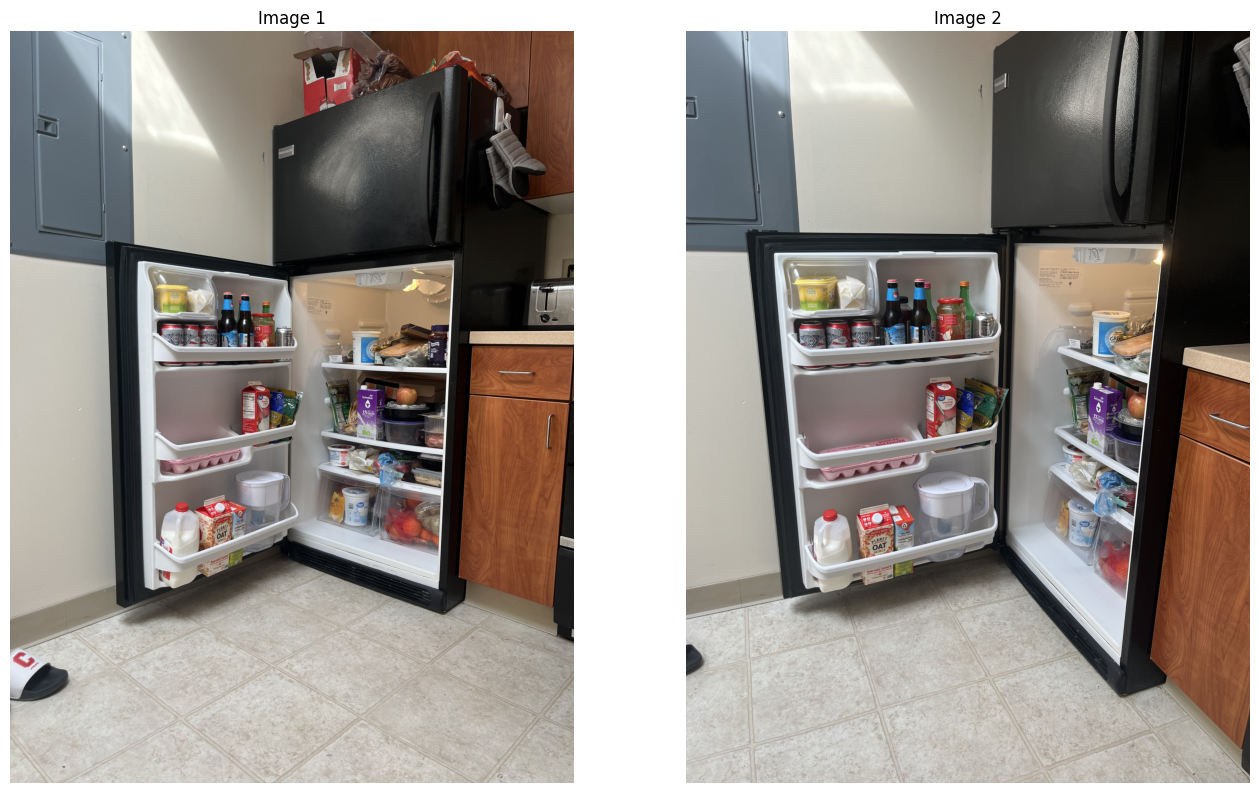

In [ ]:
## LOAD IMAGES
FACTOR = 0.75

img1 = cv2.imread(path1)
img2 = cv2.imread(path2)

# convert to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# resize
img1 = cv2.resize(img1, dsize=None, fx=FACTOR, fy=FACTOR)
img2 = cv2.resize(img2, dsize=None, fx=FACTOR, fy=FACTOR)

# show images
fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Image 1')

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Image 2')

As said before, the points were annotated manually. However, this could be done also through direct algorithms such as SIFT. The points we have found are stored in the arrays <code>points1</code> and <code>points2</code>. The order reflects the correspondences, i.e. <code>points1[i]</code> and <code>points2[i]</code> represent the same point in the two images.

In [ ]:
points1 = [(513, 1135), (1488, 1344), (612, 3094), (1084, 2614), (1652, 2345), (1966, 1930), (1693, 1882), (2506, 3192), (507, 967), (2479, 1689)]
points2 = [(324, 1082), (1671, 1197), (527, 3043), (956, 2676), (1952, 2354), (2258,1946), (2037, 1815), (2509, 3737), (387, 862), (2693, 1808)]

# rescale
points1 = [[x*FACTOR for x in point] for point in points1]
points2 = [[x*FACTOR for x in point] for point in points2]


For simplicity, we created a function, <code>convert_to_homo</code> that takes as input a list of points and converts them to homogeneous coordinates (by adding a third coordinate equal to 1).

In [ ]:
def convert_to_homo(pts):
    ''' This function takes a list of 2D points and converts them to homogeneous coordinates.'''
    return [(*point, 1) for point in pts]

Now we plot the two images and the correspondences.

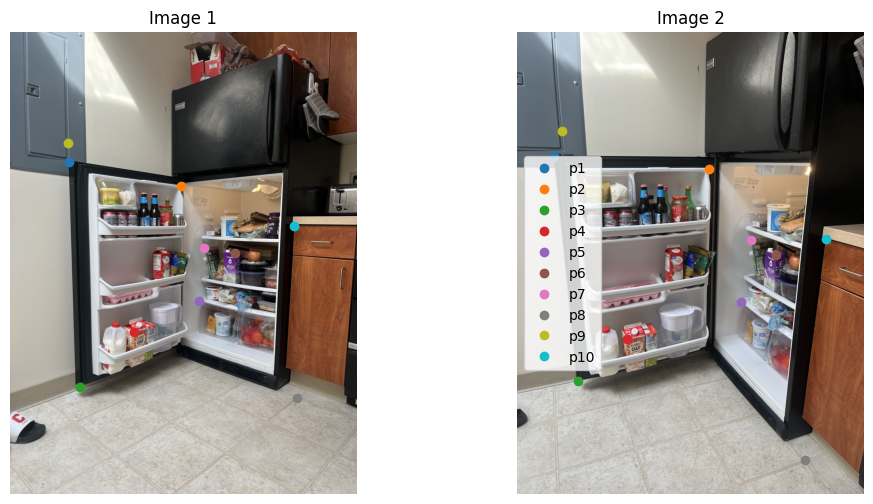

In [ ]:
## SHOW CORRESPONDENCES
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1)
axes[0].set_title('Image 1')
axes[0].axis('off')

for i, (x, y) in enumerate(points1):
    axes[0].plot(x, y, 'o', label=f'p{i+1}')

axes[1].imshow(img2)
axes[1].set_title('Image 2')
axes[1].axis('off')

for i, (x, y) in enumerate(points2):
    axes[1].plot(x, y, 'o', label=f'p{i+1}')

plt.legend()
plt.show()


Now we introduce another auxiliary function that, given a list of points, computes its normalization matrix (i.e. the transformation such that the points have mean zero and average distance from origin is square root of 2).

In [ ]:
def norm_matrix(pts):
    pts = np.float64(pts)
    mean = np.array(np.sum(pts, axis=0) / len(pts), dtype=np.float64)
    scale = np.sum(la.norm(pts - mean, axis=1), axis=0) / (len(pts) * np.sqrt(2.0))

    norm_matrix = np.array(
        [
            [1.0 / scale, 0.0, -mean[0] / scale],
            [0.0, 1.0 / scale, -mean[1] / scale],
            [0.0, 0.0, 1.0],
        ],
        dtype=np.float64,
    )

    return norm_matrix

Finally, we can write our eight points algorithm. First, we check that the two list of points have the same length and that there are at least 8 correspondences. Then, we compute normalization matrices for both lists of points and we apply them to the points in homogeneous coordinates (because the <code>convert_to_homo</code> function was built to work with homogeneous coordinates). <br>
The next step is to build the system of equations, i.e. build the matrix A as the cross product between $x_i'^T$ and $x_i^T$. Then, we solve $Az = 0$ for $z$ using SVD. We let $f$ be the vector in $V^T$ corresponding to smallest singular value and we reshape it into a $3\times 3$ matrix.<br>

Now we impose rank deficiency by first computing SVD decomposition of $f$, i.e. $f = USV^T$. Then we set smallest singular value to $0$, getting $S'$ and we compute the fundamental matrix as $F = US' V^T$. <br>

Lastly, we denormalize $F$ by pre-multiplying it by the transpose of the normalization matrix of the second set of points and post-multiplying it by the other normalization matrix. We rescale $F$ using its Frobenius norm and we are done.

In [ ]:
def eight_points_algo(pts1, pts2):
    ''' This function estimates the fundamental matrix F from n correspondences (using the 8-points-algorithm)'''
    pts1 = np.float64(pts1)
    pts2 = np.float64(pts2)
    n = len(pts1)

    assert(n == len(pts2))
    assert(n >= 8)

    # STEP 1 - NORMALIZATION
    norm_1 = norm_matrix(pts1)
    norm_2 = norm_matrix(pts2)

    pts1_homo = convert_to_homo(pts1)
    pts2_homo = convert_to_homo(pts2)

    pts1_norm = np.float64([norm_1 @ pt for pt in pts1_homo])
    pts2_norm = np.float64([norm_2 @ pt for pt in pts2_homo])

    # STEP 2 - build A
    A = np.zeros((n, 9))
    for i in range(n):
        x1, y1, w1 = pts1_norm[i]
        x2, y2, w2 = pts2_norm[i]

        A[i] = [x2*x1, x2*y1, x2*w1,
                y2*x1, y2*y1, y2*w1,
                w2*x1, w2*y1, w2*w1] # cross product

    # STEP 3 - solve Az = 0 using SVD
    _, _, V_t = la.svd(A)

    f = V_t[-1, :] # vector corresponding to smallest singular value

    f = np.float64(f.reshape((3, 3))) # reshape

    # STEP 4 - impose rank deficiency
    U, s, V_t = la.svd(f)

    s[-1] = 0 # set last singular value to zero
    s_new = np.diag(s)

    F = U @ s_new @ V_t # recompute F

    # STEP 5 - denormalize
    F = norm_2.T @ F @ norm_1
    if abs(F[2,2]) > 1e-8:
        F = F / F[2,2]
    else:
        F = F / la.norm(F, 'fro')

    return F

In [ ]:
F = eight_points_algo(points1, points2)

In [ ]:
F_true, _ = cv2.findFundamentalMat(np.array(points1), np.array(points2), method=cv2.FM_8POINT)

print("Fundamental Matrix:\n", F_true, "\n Estimated Matrix: \n", F)


Fundamental Matrix:
 [[-3.83425647e-07  1.72516763e-07  2.19351333e-03]
 [-1.06215559e-06  4.17063252e-07  6.04188771e-03]
 [-9.18560968e-04 -7.08453381e-03  1.00000000e+00]] 
 Estimated Matrix: 
 [[-3.83425647e-07  1.72516763e-07  2.19351333e-03]
 [-1.06215559e-06  4.17063252e-07  6.04188771e-03]
 [-9.18560968e-04 -7.08453381e-03  1.00000000e+00]]


In [ ]:
diff = F - F_true
print(f'Difference between the two matrices is: \n{diff}')

Difference between the two matrices is: 
[[ 1.91641204e-20 -1.94738169e-19  3.23525928e-16]
 [ 3.65494717e-19 -9.55559044e-20 -6.02816408e-16]
 [-6.49870782e-16  7.71084585e-16  0.00000000e+00]]


We see that the difference is not exctly zero, however the matrices are very close. This can be assessed also with the following lines of code:

In [ ]:
if np.allclose(F, F_true, atol=1e-8):  # 'atol' sets an acceptable error margin
    print("The matrices are numerically equivalent.")
else:
    print("The matrices are different.")

The matrices are numerically equivalent.


## **Epipolar Lines**

The next task is to compute the epipolar lines. We create a function that receives as input the two sets of points and the fundamental matrix (which we found using the 8-points-algorithm) and outputs a list of epipolar lines each in the form $[a, b, c]$ (representing the line $ax + by + c = 0$). <br>

The lines in the first image are computed as $F^T \otimes x_i'$ and the lines in the second image are computed as $F \otimes x_i$. We then compute the intersection with the image borders and plot the results.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_epipolar_lines(img1, img2, pts1, pts2, F):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    n = len(pts1)
    axes[0].imshow(img1)
    axes[0].set_title('Image 1')
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].set_title('Image 2')
    axes[1].axis('off')

    pts1_homo = np.array(convert_to_homo(pts1))
    pts2_homo = np.array(convert_to_homo(pts2))

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    def plot_line_safely(ax, w, h, line, color='r'):
        a, b, c = line

        if abs(b) < 1e-10:
            return False

        # intersections
        x_intersects = []
        y_intersects = []

        if b != 0:
            x_top = -c / a if a != 0 else float('inf')
            if 0 <= x_top <= w:
                x_intersects.append(x_top)
                y_intersects.append(0)

        x_bottom = -(b * h + c) / a if a != 0 else float('inf')
        if 0 <= x_bottom <= w:
            x_intersects.append(x_bottom)
            y_intersects.append(h)

        y_left = -c / b
        if 0 <= y_left <= h:
            x_intersects.append(0)
            y_intersects.append(y_left)

        y_right = -(a * w + c) / b
        if 0 <= y_right <= h:
            x_intersects.append(w)
            y_intersects.append(y_right)

        if len(x_intersects) >= 2:
            ax.plot(x_intersects, y_intersects, color, linewidth=1)
            return True

        return False

    # IMAGE 2
    for i in range(n):
        line = F @ pts1_homo[i]
        plot_line_safely(axes[1], w2, h2, line, 'r')

    # IMAGE 1
    for i in range(n):
        line = F.T @ pts2_homo[i]
        plot_line_safely(axes[0], w1, h1, line, 'b')

    axes[0].plot(np.array(pts1)[:, 0], np.array(pts1)[:, 1], 'go', markersize=5)
    axes[1].plot(np.array(pts2)[:, 0], np.array(pts2)[:, 1], 'go', markersize=5)

    plt.tight_layout()
    plt.show()

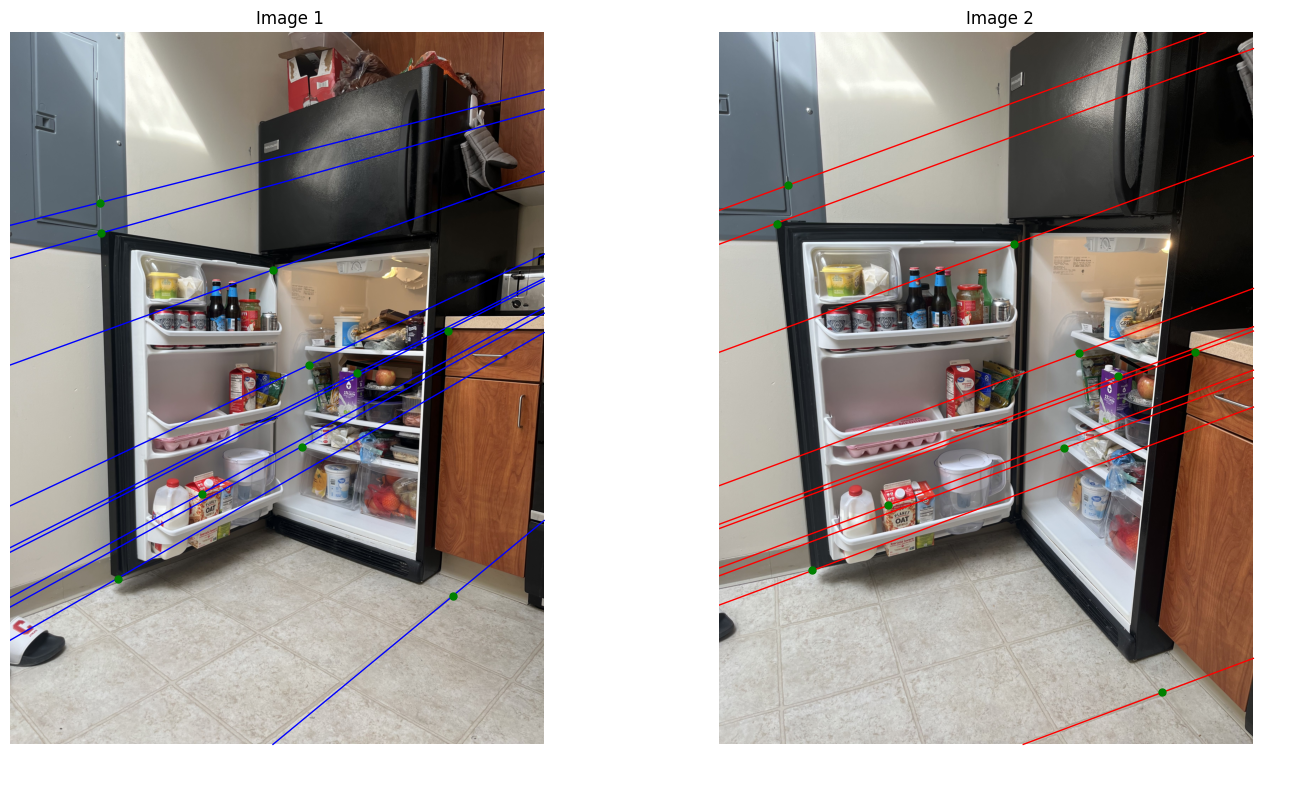

In [ ]:
plot_epipolar_lines(img1, img2, points1, points2, F)


## **Epipolar Error**
The last step is to use a geometric error to see how good our estimate is. To do so, we compute the symmetric epipolar distance between points and their epipolar lines. <br>
For each index $i = 1,...,n$, where $n$ is the number of correspondences, we compute the epipolar line in image 1 corresponding to $x_i'$ and the epipolar line in image 2 corresponding to $x_i$. <br>

Then, we compute the normalized distance of the point in image 1 with the epipolar line in image 1 and same for image 2. For points in image 1, this will be
$$\frac{|x_i^T F^T x_i'|}{\sqrt{(a^2+b^2)}}$$
where $a^2, b^2$ are the parameters of the line, i.e. the line is defined as $[a, b, c]$.  <br>

For each $i$ we then compute the mean of these two distances.

In [ ]:
def compute_epipolar_error(pts1, pts2, F):
    pts1_homo = np.array(convert_to_homo(pts1))
    pts2_homo = np.array(convert_to_homo(pts2))

    n = len(pts1)

    errors = np.zeros(n)

    for i in range(n):
        line2 = F @ pts1_homo[i]
        line1 = F.T @ pts2_homo[i]

        # POINT TO LINE DISTANCES:
        # distance from pt2 to line in image 2: |pt2^T * F * pt1| / sqrt((F*pt1)_1^2 + (F*pt1)_2^2)
        # distance from pt1 to line in image 1: |pt1^T * F^T * pt2| / sqrt((F^T*pt2)_1^2 + (F^T*pt2)_2^2)

        num1 = abs(pts1_homo[i].T @ F.T @ pts2_homo[i])
        num2 = abs(pts2_homo[i].T @ F @ pts1_homo[i])

        denom1 = np.sqrt(line1[0]**2 + line1[1]**2)
        denom2 = np.sqrt(line2[0]**2 + line2[1]**2)

        d1 = num1 / denom1
        d2 = num2 / denom2

        errors[i] = (d1 + d2) / 2  # average of distances

    mean_error = errors.mean()

    return mean_error, errors

In [ ]:
mean_error, errors = compute_epipolar_error(points1, points2, F)

print(f"Mean epipolar distance: {mean_error:.6f} pixels")
print(f"Max epipolar distance: {errors.max():.6f} pixels")
print(f"Min epipolar distance: {errors.min():.6f} pixels")


Mean epipolar distance: 1.504677 pixels
Max epipolar distance: 3.299697 pixels
Min epipolar distance: 0.084218 pixels
